In [1]:
from read_db.CH import Getch
import pandahouse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import swifter
from scipy import stats
import sqlite3
import re

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Contents

* [0. Project description](#descript)
* [1. A/A-test](#aa_test)
    * [Get the data](#get_data1)
    * [Check data similarity visually](#vis1)
    * [Check the data by t-test](#ttest1)
    * [Check the data by Mann–Whitney U test](#mwh1)
    * [Same tests in clickhouse only](#click_test1)
    * [Simulation of 10000 A/A tests](#sumilation_aa)
    * [Distribution of p-value](#pval_dist)
    * [Conclusion about A/A test](#conc1)
* [2. A/B-test](#ab_test)
    * [2.0 The main question](#question)
    * [2.1 Raw CTR](#raw_ctr)
        * [Get the data](#get_data2)
        * [Check the groups visually](#vis2)
        * [Calculate group global CTR](#group_ctr)
        * [Check the data by t-test](#ttest2)
        * [Check the data by Mann–Whitney U test](#mwh2)
        * [Same tests in clickhouse only](#click_test2)
    * [2.2 Poisson Bootstrap weighted data](#poisson)
        * [Get the data](#poisson_data)
        * [Calculations for bootstrap](#poisson_calc)
        * [Plot the distribution](#poisson_plot)
        * [Statistical tests on bootstrap](#poisson_stat)
    * [2.3 Smoothed CTR](#smoothed)
        * [Smooth the CTR](#smooth_calc)
        * [Plot the distribution](#smoothed_plot)
        * [Statistical tests on smoothed CTR](#smooth_stat)
    * [2.4 Bucket transformation](#bucket_trans)
        * [Split on 50 buckets](#split50)
        * [Calculate 20% and 80% quantile](#20_80)
        * [Plot the distribution of CTR from buckets](#plt_bucket)
        * [Statistical tests on buckets](#stat_bucket)
    * [2.5 Conclusion for A/B test](#ab_conc)
    * [2.6 Linearized metric - addition](#linear)
        * [Get the data](#lin_data)
        * [Check data similarity visually](#lin_vis)
        * [Calculating Linearized likes for groups](#lin_calc)
        * [Plotting new metric - Linearized likes](#lin_plot)
        * [Check the groups by t-test](#lin_ttest)
        * [Check the groups by Mann–Whitney U test](#lin_mwh)
        * [Additional tests of raw CTR to get complete picture](#additional)
        * [Construct the table for conclusions](#table)
        * [Conclusion about our groups and the Linearized likes metric](#lin_conc)
    * [2.7 General Conclusion](#gen_conc)
* [3. Next steps](#next)

# 0. Project description <a class="anchor" id="descript"></a>
We have the Newsfeed service. There are users watching posts, users can like some post. The new recommendation algorithm was applied for part of our users. We will measure the involvement of our users by <b>CTR</b> metric - likes divided by views.<br>
We will test:
* If our groups really were the same before new algorithm (AA-test)
* Is the group with new algo different from the control group (AB-test)

We have 4 groups in our experiment:
   * group 0 - control
   * group 1 - control
   * group 2 - Recommending posts similar to liked by user before
   * group 3 - Recommending posts liked by other similar users
<br>
<br>
AB test started at '2022-04-04', finished after '2022-04-10'

**We can get the data from the server with clickhouse database or from the local storage* 

# 1. A/A-test <a class="anchor" id="aa_test"></a>
For AA test we will take the data between '2022-03-28' and '2022-04-03' - groups 2 and 3 before new algorythms. <br>

### Get the data <a class="anchor" id="get_data1"></a>

#### Get likes, views, CTR for two groups (from clickhouse)

In [2]:
# get the data from clickhouse
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as CTR
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-03-28' and '2022-04-03'
    and exp_group in (2, 3)
GROUP BY exp_group, user_id
"""

df = Getch(q).df
df.groupby('exp_group').count()

,user_id,likes,views,CTR
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


#### Get likes, views, CTR for two groups (local data)

In [3]:
# function for local db
def read_local_db(query, test, groups): 
    if test == 'AA':
        table_name = 'users_for_aa_test'
        dates = ["'2022-03-28'", "'2022-04-03'"]
    else:
        table_name = 'users_for_ab_test'
        dates = ["'2022-04-04'", "'2022-04-10'"]
    con = sqlite3.connect('data\data_mnths\\'+table_name+'.db')
    query = re.sub('_table_' , table_name, query)
    query = re.sub('start_date' , dates[0], query)
    query = re.sub('finish_date' , dates[1], query)
    query = re.sub('_groups_' , groups, query)
    df = pd.read_sql(query, con)
    df = df.fillna(0)
    df['CTR'] = df['likes'] / df['views']
    return df

In [4]:
q_local = """SELECT 
                t1.exp_group AS exp_group
              , t1.user_id AS user_id
              , likes
              , views
                FROM
            (SELECT exp_group 
                 , user_id 
                 , count(action) AS views
            FROM _table_ 
            WHERE action = 'view' AND Date(time) between start_date and finish_date
            GROUP BY exp_group, user_id
            ) t1
            LEFT JOIN
            (SELECT exp_group 
                 , user_id 
                 , count(action) AS likes
            FROM _table_ 
            WHERE action = 'like' AND Date(time) between start_date and finish_date
            GROUP BY exp_group, user_id
            ) t2 ON t1.exp_group=t2.exp_group AND t1.user_id=t2.user_id
            WHERE t1.exp_group in _groups_"""

In [5]:
# get the data for aa test (groups 2, 3) 
df = read_local_db(q_local, 'AA', '(2, 3)')

In [6]:
df.groupby('exp_group').count()

,user_id,likes,views,CTR
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


We have two groups almost the same size, next step is to visualize their's CTR distribution

### Check data similarity visually <a class="anchor" id="vis1"></a>

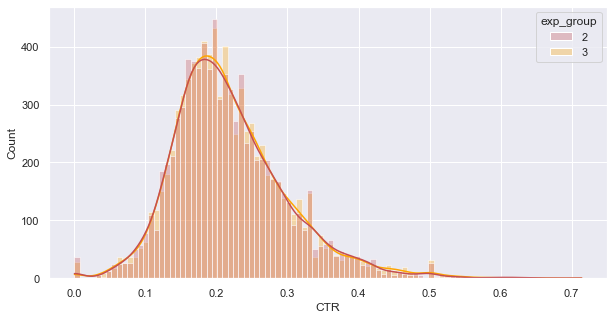

In [7]:
sns.set(rc={'figure.figsize':(10, 5)}) 
groups = sns.histplot(data = df, 
              x='CTR', 
              hue='exp_group', 
              palette = ['r', 'orange'],
              alpha=0.3,
              kde=True)

Looks very close, now we will test is statistically

### Check data similarity by t-test <a class="anchor" id="ttest1"></a>

In [8]:
df_2 = df[df.exp_group == 2]
df_3 = df[df.exp_group == 3]
# df_3.head()

In [9]:
# get group CTR
group_ctr_2 = df_2.likes.sum()/df_2.views.sum()
group_ctr_3 = df_3.likes.sum()/df_3.views.sum()
print('global CTR for group 2: ', group_ctr_2, '\n', 'global CTR for group 3: ', group_ctr_3, sep='')

global CTR for group 2: 0.21136726847959333
global CTR for group 3: 0.2107055278977798


In [10]:
statistic, p_value = stats.ttest_ind(df_2.CTR, df_3.CTR, equal_var=False)
print(statistic, p_value, '\n')
if p_value > 0.05:
    print('p value > 0.05, CTR of groups looks similar by t-test')
else:
    print('p value <= 0.05, CTR of groups looks different by t-test')
stats.ttest_ind(df_2.CTR, df_3.CTR, equal_var=False)

-0.7393597924958364 0.45969873156476293 

p value > 0.05, CTR of groups looks similar by t-test


Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [11]:
stats.ttest_ind(df_2.CTR, df_3.CTR, equal_var=True) # just to check if same dispersion could give us much different p-value

Ttest_indResult(statistic=-0.7393459522174748, pvalue=0.45970713287025744)

### Check data similarity by Mann–Whitney U test <a class="anchor" id="mwh1"></a>

In [12]:
U1, p_value = stats.mannwhitneyu(df_2.CTR, df_3.CTR, alternative='two-sided')
print(U1, p_value, '\n')
if p_value > 0.05:
    print('p value > 0.05, CTR of groups looks similar by Mann–Whitney U test')
else:
    print('p value <= 0.05, CTR of groups looks different by Mann–Whitney U test')
stats.mannwhitneyu(df_2.CTR, df_3.CTR, alternative='two-sided')

36124728.5 0.5177480614337441 

p value > 0.05, CTR of groups looks similar by Mann–Whitney U test


MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)

### Same tests in clickhouse only <a class="anchor" id="click_test1"></a>
Clickhouse have built-in functions to do those tests, the query then looks like:

In [13]:
# t-test in clickhouse
q = '''WITH welchTTest(ctr, exp_index) as ttest

select tupleElement(ttest, 1) as statistic,
    tupleElement(ttest, 2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 2 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-03-28' and '2022-04-03'
        and exp_group in (2, 3)
    GROUP BY exp_group, user_id)'''
df = Getch(q).df
print(df.p_value)
df

0   0.46
Name: p_value, dtype: float64


,statistic,p_value
0,-0.74,0.46


In [14]:
# Mann–Whitney U test in clickhouse
q = '''WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

select tupleElement(mw, 1) as statistic,
    tupleElement(mw, 2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 2 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-03-28' and '2022-04-03'
        and exp_group in (2, 3)
    GROUP BY exp_group, user_id)'''
df = Getch(q).df
print(df.p_value)
df

0   0.48
Name: p_value, dtype: float64


,statistic,p_value
0,"36,106,477.50",0.48


### Simulation of 10000 A/A tests <a class="anchor" id="sumilation_aa"></a>
Check 10000 pseudo A/A tests by choosing 500 random from two groups

In [15]:
# from clickhouse
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as CTR
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-03-28' and '2022-04-03'
    and exp_group in (2 ,3)
GROUP BY exp_group, user_id
"""
df = Getch(q).df
df_2 = df[df.exp_group == 2]
df_3 = df[df.exp_group == 3]

In [16]:
# df_2
# df_3

In [17]:
# from local db
df = read_local_db(q_local, 'AA', '(2, 3)')
df_2 = df[df.exp_group == 2]
df_3 = df[df.exp_group == 3]

We will make a simulation - like we did 10000 tests on subsets of 500 users each one

In [18]:
def subgroup_simulation(df_2, df_3, crop_len, n):

    # get global ctrs for n groups by size of <crop_len>
    global_ctr_2_list = []
    global_ctr_3_list = []
    p_value_list = []
    
    for i in range(n):
        df_2_crop= df_2.sample(crop_len, replace=True)
        global_ctr_2 = df_2_crop.likes.sum()/df_2_crop.views.sum()
        global_ctr_2_list.append(global_ctr_2)
        
        df_3_crop= df_3.sample(crop_len, replace=True)        
        global_ctr_3 = df_3_crop.likes.sum()/df_3_crop.views.sum()
        global_ctr_3_list.append(global_ctr_3)
    
        statistic, p_value = stats.ttest_ind(df_2_crop.CTR, df_3_crop.CTR, equal_var=False)
        p_value_list.append(p_value)
        
    return global_ctr_2_list, global_ctr_3_list, p_value_list

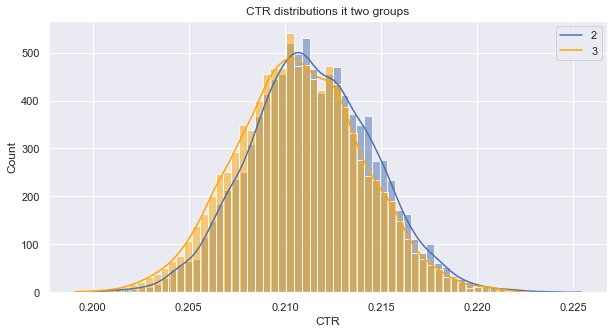

In [19]:
# simulation
global_ctr_2_list, global_ctr_3_list, p_value_list = subgroup_simulation(df_2, df_3, 500, 10000)
# plot
sns.histplot(global_ctr_2_list, kde=True, alpha=.5)
sns.histplot(global_ctr_3_list, kde=True, alpha=.5, color = 'orange')
plt.title('CTR distributions it two groups')
plt.xlabel('CTR')
plt.legend(['2', '3'])
plt.show()

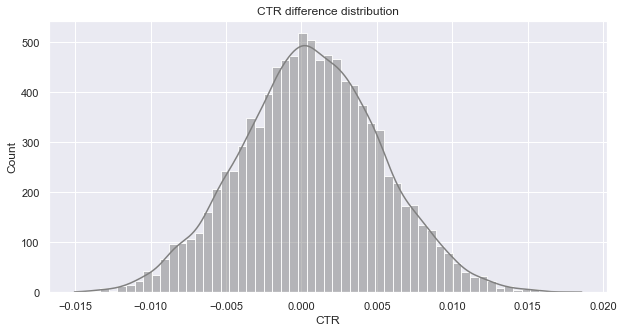

In [20]:
# calculate and plot the difference
sns.histplot(np.asarray(global_ctr_2_list) - np.asarray(global_ctr_3_list), kde=True, color='grey')
plt.title('CTR difference distribution')
plt.xlabel('CTR')
plt.show()

We observe here that the difference between two groups CTR distribution is near the zero, so we can say that groups are similar

### Distribution of p-value <a class="anchor" id="pval_dist"></a>

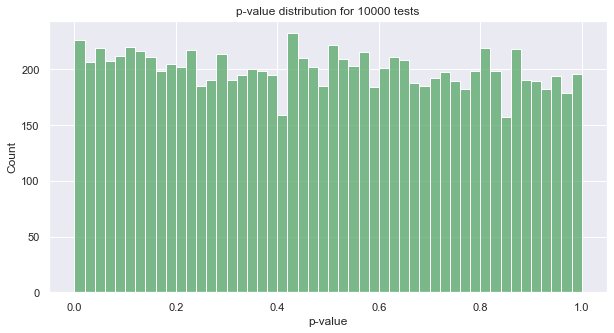

In [21]:
# print(len(p_value_list))
# p_value_list[:10]
sns.histplot(p_value_list, bins=50, color='g')
plt.title('p-value distribution for 10000 tests')
plt.xlabel('p-value')
plt.show()

In [22]:
low_p_counter = 0
for p in p_value_list:
    if p <= .05:
        low_p_counter += 1
print('Number of p-values <= 0.05:', low_p_counter)
print('Total number of p-values in list:', len(p_value_list))
print(f'Percent of p-values <= 0.05:', f'{low_p_counter/len(p_value_list)*100}%')

Number of p-values <= 0.05: 527
Total number of p-values in list: 10000
Percent of p-values <= 0.05: 5.27%


We have uniformly distributed P-value, it is also indicates the similarity of our two groups

### Conclusion about A/A test <a class="anchor" id="conc1"></a>

Two groups are similar by all statistic tests and visually, on raw CTR and on simulated subsets. From the simulation we get p-values, they have uniform distribution - it is expected for similar groups. <BR> Next step is A/B testing: in next period of time two groups will get new algorithms for posts recommendation to users

***

# 2. A/B test <a class="anchor" id="ab_test"></a>

### 2.0 The main question <a class="anchor" id="question"></a>

We have the new data from the period of A/B test:

Group 2 have new recommendations algorythm, 1 is the control group <br>
The question is: <i>"Does the CTR in group 2 different from the CTR in group 1?"</i>

We will compare the data:<br>
 * visually
 * by t-test
 * by Mann–Whitney U test
 * after Poisson bootstrap (t-test + MW)
 * by smoothed CTR (t-test + MW)
 * after bucket transformation (t-test + MW)

## 2.1 Raw CTR <a class="anchor" id="raw_ctr"></a>

### Get the data <a class="anchor" id="get_data2"></a>

#### Get the data from clickhouse

In [23]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as CTR
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""
df = Getch(q).df
df.groupby('exp_group').count()

,user_id,likes,views,CTR
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


#### Get the data from local storage

In [24]:
df = read_local_db(q_local, 'AB', '(1, 2)')
df.groupby('exp_group').count()

,user_id,likes,views,CTR
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [25]:
df.head()

,exp_group,user_id,likes,views,CTR
0,1,206,6.00,38,0.16
1,1,216,3.00,27,0.11
2,1,243,15.00,95,0.16
3,1,274,16.00,102,0.16
4,1,276,11.00,32,0.34


### Check the groups visually <a class="anchor" id="vis2"></a>

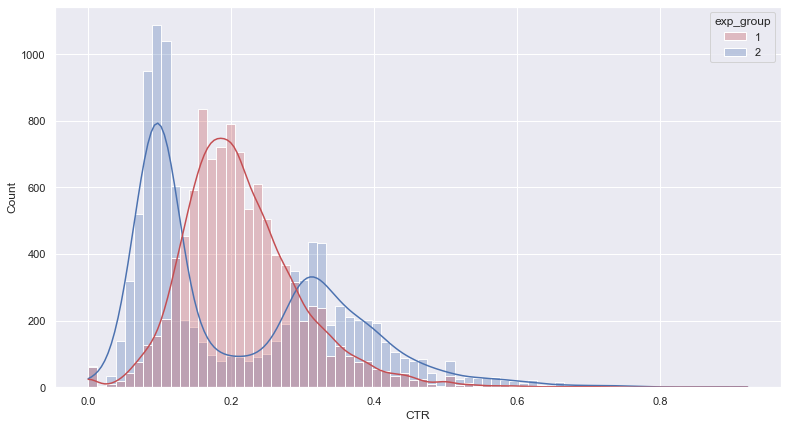

In [26]:
sns.set(rc={'figure.figsize':(13, 7)}) 
groups = sns.histplot(data = df, 
              x='CTR', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.3,
              kde=True)

Group 2 distribution looks bimodal, new algorithm did something strange

### Calculate group global CTR <a class="anchor" id="group_ctr"></a>

In [27]:
df_2 = df[df.exp_group == 2]
df_1 = df[df.exp_group == 1]
# df_1.head()

In [28]:
# get group CTR
group_ctr_1 = df_1.likes.sum()/df_1.views.sum()
group_ctr_2 = df_2.likes.sum()/df_2.views.sum()
print('global CTR for group 1: ', group_ctr_2, '\n', 'global CTR for group 2: ', group_ctr_1, sep='')

global CTR for group 1: 0.1980601844115994
global CTR for group 2: 0.20802680490126244


Global CTR between group is slightly different, but can we say that group 2 is better by only one number? Let's do more tests

### Check data similarity by t-test <a class="anchor" id="ttest2"></a>

In [29]:
# function to print test result
def print_p_value(p_value, alpha, test_type): 
    print('p value:', p_value)
    if p_value > alpha:
        print(f'p value > {alpha}, CTR of two groups looks similar by {test_type}')
    else:
        print(f'p value <= {alpha}, CTR of two groups looks different by {test_type}')

In [30]:
statistic, p_value = stats.ttest_ind(df_2.CTR, df_1.CTR, equal_var=False)
print_p_value(p_value, .05, 't-test')    
stats.ttest_ind(df_2.CTR, df_1.CTR, equal_var=False)

p value: 0.4780623130875141
p value > 0.05, CTR of two groups looks similar by t-test


Ttest_indResult(statistic=-0.7094392041270153, pvalue=0.4780623130875141)

t-test working with average values, for such bimodal distribution it easily could be wrong

### Check data similarity by Mann–Whitney U test <a class="anchor" id="mwh2"></a>

In [31]:
U1, p_value = stats.mannwhitneyu(df_2.CTR, df_1.CTR, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test')    
stats.mannwhitneyu(df_2.CTR, df_1.CTR, alternative='two-sided')

p value: 6.03764846177773e-56
p value <= 0.05, CTR of two groups looks different by Mann–Whitney U test


MannwhitneyuResult(statistic=43704947.5, pvalue=6.03764846177773e-56)

P value is extremely small, so there is a significant difference between the groups

### Same tests in clickhouse only <a class="anchor" id="click_test2"></a>
Clickhouse have built-in functions to do those tests, will use it again for new groups:

In [32]:
# t-test in clickhouse
q = '''WITH welchTTest(ctr, exp_index) as ttest

select tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 2 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (2, 1)
    GROUP BY exp_group, user_id)'''
df = Getch(q).df
print(df.p_value)
df

0   0.48
Name: p_value, dtype: float64


,statistic,p_value
0,-0.71,0.48


In [33]:
# Mann–Whitney U test in clickhouse
q = '''WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

select tupleElement(mw,1) as statistic,
    tupleElement(mw,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 2 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (2 ,1)
    GROUP BY exp_group, user_id)'''
df = Getch(q).df
print(df.p_value)
df

0   0.00
Name: p_value, dtype: float64


,statistic,p_value
0,"43,707,009.50",0.00


P values calculated by clickhouse are slightly different, but generally give us same answers

***

## 2.2 Poisson Bootstrap weighted data <a class="anchor" id="poisson"></a>
We will generate 2000 sets from our original data by applying Poisson distribution for weights

#### Get the data <a class="anchor" id="poisson_data"></a>

In [34]:
# get data clickhouse
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (2 ,1)
GROUP BY exp_group, user_id
"""
df = Getch(q).df

In [35]:
# get data local
df = read_local_db(q_local, 'AB', '(1, 2)')
# df

#### Calculations for bootstrap<a class="anchor" id="poisson_calc"></a>

Construct arrays of views and likes for two groups

In [36]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [37]:
views2

array([33,  9, 29, ..., 84, 73,  1], dtype=int64)

In [38]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    # get the number of times for user to be in the subset by Poisson distribution (weights)
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    # calculate global ctrs
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

#### Plot the distribution  <a class="anchor" id="poisson_plot"></a>

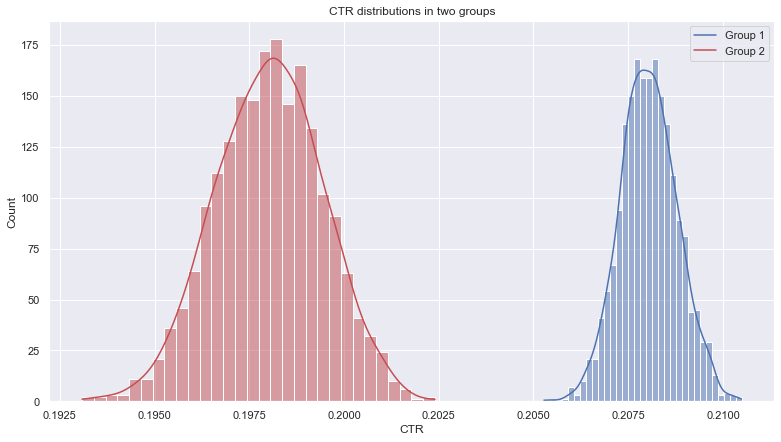

In [39]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, kde=True)
sns.histplot(ctr2, color = 'r', kde=True)
plt.title('CTR distributions in two groups')
plt.xlabel('CTR')
plt.legend(['Group 1', 'Group 2'])
plt.show()

Here we observe the group CTRs distribution for each group. Difference isn't so significant in absolute numbers, but more important here that there is no intersection between two groups. <br>Conclusion from poisson bootstrap is that group CTR in group 2 is lower, so new algo is'n good. <br>Anyway we will continue to explore the data wtih another tests

#### Statistical tests on bootstrap <a class="anchor" id="poisson_stat"></a>

In [40]:
# t-test, it will be zero, but I want to check it anyway to be absolutely sure
statistic, p_value = stats.ttest_ind(ctr1, ctr2, equal_var=False)
print_p_value(p_value, .05, 't-test')    
stats.ttest_ind(ctr1, ctr2, equal_var=False)

p value: 0.0
p value <= 0.05, CTR of two groups looks different by t-test


Ttest_indResult(statistic=279.70506843465046, pvalue=0.0)

Zero it is, like expected

In [41]:
# MW U test, also zero for sure
statistic, p_value = stats.mannwhitneyu(ctr1, ctr2, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test')    
stats.mannwhitneyu(ctr1, ctr2, alternative='two-sided')

p value: 0.0
p value <= 0.05, CTR of two groups looks different by Mann–Whitney U test


MannwhitneyuResult(statistic=4000000.0, pvalue=0.0)

***

## 2.3 Smoothed CTR <a class="anchor" id="smoothed"></a>
Another way to check differences in some metic is to smooth the metric. We will do it on CTR to avoid distortion of less active users (with no likes for example)

In [42]:
# function to smooth ctr
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [43]:
df_2 = df[df.exp_group == 2]
df_1 = df[df.exp_group == 1]
df_1.head()

,exp_group,user_id,likes,views,CTR
0,1,206,6.00,38,0.16
1,1,216,3.00,27,0.11
2,1,243,15.00,95,0.16
3,1,274,16.00,102,0.16
4,1,276,11.00,32,0.34


Will smooth CTRs in groups and visualize them to compare distributions

#### Smooth the CTR <a class="anchor" id="smooth_calc"></a>

In [44]:
alph = 5 # smoothing coef
group1 = df_1.copy()
group2 = df_2.copy()

group1['smothed_ctr'] = df_1.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], group_ctr_1, alph), axis=1)
group2['smothed_ctr'] = df_2.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], group_ctr_2, alph), axis=1)

#### Plot the distribution<a class="anchor" id="smoothed_plot"></a>

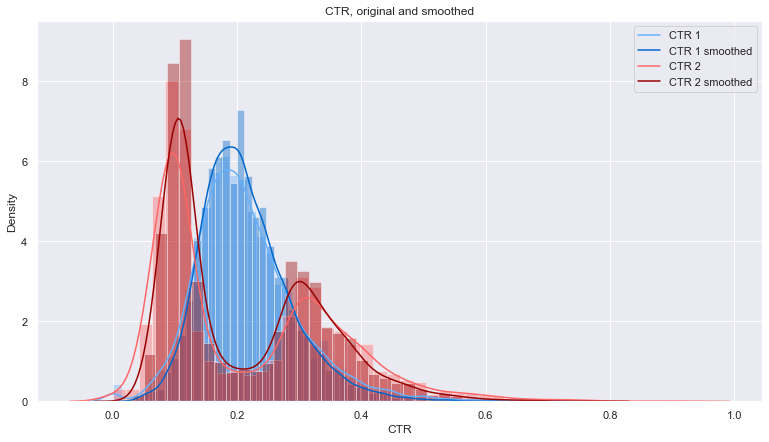

In [45]:
kde_bool = True
sns.distplot(group1.CTR, kde = kde_bool, color='#66B2FF')
sns.distplot(group1.smothed_ctr, kde = kde_bool, color='#0066CC')
sns.distplot(group2.CTR, kde = kde_bool, color='#FF6666')
sns.distplot(group2.smothed_ctr, kde = kde_bool, color='#990000')
plt.legend(['CTR 1', 'CTR 1 smoothed', 'CTR 2', 'CTR 2 smoothed'])
plt.xlabel('CTR')
plt.title('CTR, original and smoothed')
plt.show()

Our distributions of smoothed CTR are more sharp and concentrated

#### Statistical tests  on smoothed CTR<a class="anchor" id="smooth_stat"></a>

Smoothed CTR t-test

In [46]:
statistic, p_value = stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)
print_p_value(p_value, .05, 't-test')    
stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)

p value: 0.022376981555854755
p value <= 0.05, CTR of two groups looks different by t-test


Ttest_indResult(statistic=2.284132043161718, pvalue=0.022376981555854755)

Recalling that original (not smoothed) CTR give us another result!

In [47]:
statistic, p_value = stats.ttest_ind(group1.CTR, group2.CTR, equal_var=False)
print_p_value(p_value, .05, 't-test')    
stats.ttest_ind(group1.CTR, group2.CTR, equal_var=False)

p value: 0.4780623130875141
p value > 0.05, CTR of two groups looks similar by t-test


Ttest_indResult(statistic=0.7094392041270153, pvalue=0.4780623130875141)

Smoothed CTR, Mann–Whitney U test

In [48]:
U1, p_value = stats.mannwhitneyu(group1.smothed_ctr, group2.smothed_ctr, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test') 
stats.mannwhitneyu(group1.smothed_ctr, group2.smothed_ctr, alternative='two-sided')

p value: 1.6163964114270227e-61
p value <= 0.05, CTR of two groups looks different by Mann–Whitney U test


MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

For some reason t-test on smoothed CTR catch the differences, with p value only twise lower than our alpha, when Mann-Whitney give us p value extrimely low, so it's far more clear that we have a differencies here

***

## 2.4 Bucket transformation <a class="anchor" id="bucket_trans"></a>
Another approach is to split our users to buckets and then analyse those new 'metausers'. <br>Will implement it with 50 buckets and calculte group CTR, 20% quantile CTR and 80% qantile CTR

In [49]:
# get data
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.8)(ctr) as ctr80,
    quantileExact(0.2)(ctr) as ctr20
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = Getch(q).df

In [50]:
# df#.head()

#### Split on 50 buckets <a class="anchor" id="split50"></a>

In [51]:
# get data and split locally
def salt_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [52]:
# get the data
df = read_local_db(q_local, 'AB', '(1, 2)') 
# split on 50 buckets
df['bucket'] = df.user_id.swifter.apply(salt_split)

Pandas Apply:   0%|          | 0/20031 [00:00<?, ?it/s]

In [53]:
# check if divided equally enough
# df.groupby('bucket').user_id.nunique().reset_index()

In [54]:
# split on groups 1 and 2 to calculate bucket ctr
df_1 = df[df.exp_group == 1]
df_2 = df[df.exp_group == 2]

#### Calculate 20% and 80% quantile <a class="anchor" id="20_80"></a>

In [55]:
# get 20% and 80% CTR by buckets
def get_ntile_ctr_bucket(df, quantile):
    buckets = df.bucket.nunique()
    bucket_list = []
    ctr_list = []
    for bucket in range(buckets):
        df_current = df[df.bucket == bucket]
        ctr = df_current['CTR'].quantile(q=quantile)
        bucket_list.append(bucket)
        ctr_list.append(ctr)
    return bucket_list, ctr_list

In [56]:
# construct bucket ctr table
def convert_to_bucket_ctr(df):
    df_ctr = pd.DataFrame()
    df_ctr['bucket_ctr'] = df.groupby('bucket')['likes'].sum() / df.groupby('bucket')['views'].sum()
    _, df_ctr['ctr80'] = get_ntile_ctr_bucket(df, .8)
    _, df_ctr['ctr20'] = get_ntile_ctr_bucket(df, .2)

    df_ctr = df_ctr.reset_index()
    df_ctr['exp_group'] = df['exp_group'].iloc[0] 
    return df_ctr

In [57]:
# convert global user data table to bucket ctr table
df_1 = convert_to_bucket_ctr(df_1)
df_2 = convert_to_bucket_ctr(df_2)

#### Plot the distribution of CTR from buckets <a class="anchor" id="plt_bucket"></a>

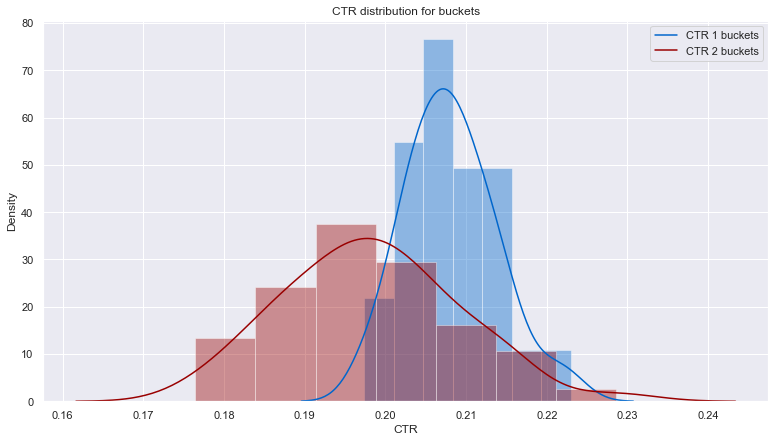

In [58]:
# plot buckets CTR
sns.distplot(df_1.bucket_ctr, kde = kde_bool, color='#0066CC')
sns.distplot(df_2.bucket_ctr, kde = kde_bool, color='#990000')
plt.legend(['CTR 1 buckets', 'CTR 2 buckets'])
plt.xlabel('CTR')
plt.title('CTR distribution for buckets')
plt.show()

There are differencies on group CTR, but will be even more interesting to look on quantiles 0.2 and 0.8

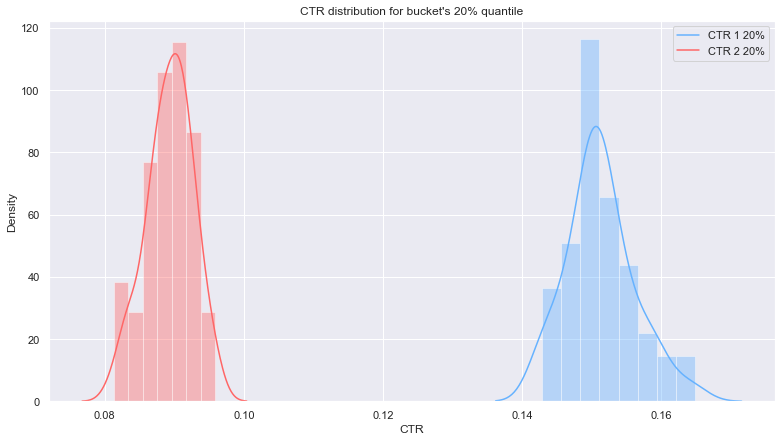

In [59]:
# plot buckets 20% quantile CTR
sns.distplot(df_1.ctr20, kde = kde_bool, color='#66B2FF')
sns.distplot(df_2.ctr20, kde = kde_bool, color='#FF6666')
plt.legend(['CTR 1 20%', 'CTR 2 20%'])
plt.xlabel('CTR')
plt.title('CTR distribution for bucket\'s 20% quantile')
plt.show()

Much different! CTR distributioans in two groups are far away one from another!

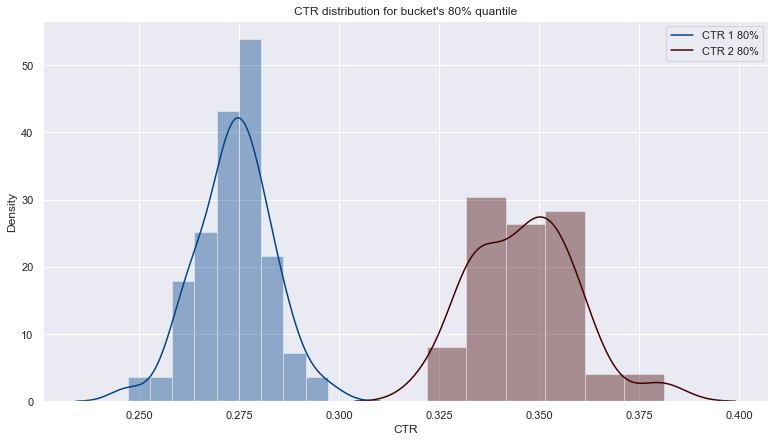

In [60]:
# plot buckets 90% quantile CTR
sns.distplot(df_1.ctr80, kde = kde_bool, color='#004488')
sns.distplot(df_2.ctr80, kde = kde_bool, color='#440000')
plt.legend(['CTR 1 80%', 'CTR 2 80%'])
plt.xlabel('CTR')
plt.title('CTR distribution for bucket\'s 80% quantile')
plt.show()

Here it's different too, with minimal overlapping CTRs in two groups are almost separate

Let's plot them all to get the picture and trends

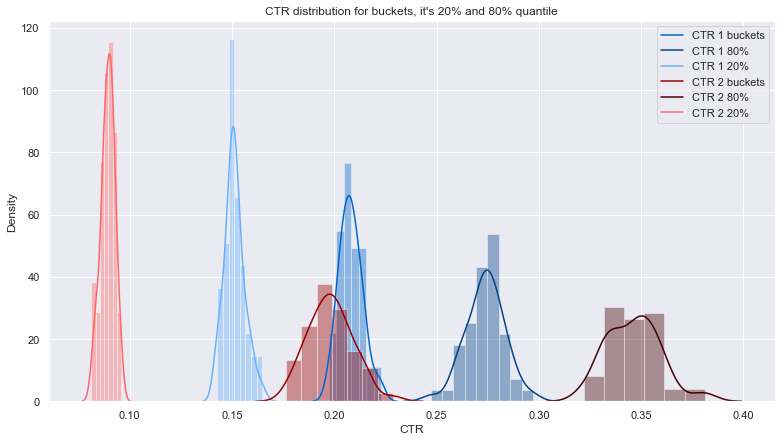

In [61]:
# plot all
sns.distplot(df_1.bucket_ctr, kde = kde_bool, color='#0066CC')
sns.distplot(df_1.ctr80, kde = kde_bool, color='#004488')
sns.distplot(df_1.ctr20, kde = kde_bool, color='#66B2FF')

sns.distplot(df_2.bucket_ctr, kde = kde_bool, color='#990000')
sns.distplot(df_2.ctr80, kde = kde_bool, color='#440000')
sns.distplot(df_2.ctr20, kde = kde_bool, color='#FF6666')

plt.legend(['CTR 1 buckets', 'CTR 1 80%', 'CTR 1 20%', 'CTR 2 buckets', 'CTR 2 80%', 'CTR 2 20%'])
plt.xlabel('CTR')
plt.title('CTR distribution for buckets, it\'s 20% and 80% quantile')
plt.show()

Recalling grooup 2 have the new algo for recommendations, group 1 is control<br>
We observe here clearly that trends intensified - who did more likes before now make even more (with new recommendations algo), who liked less - make even less likes. Maybe there are not the same people, but the trand is clear

#### Statistical tests on buckets <a class="anchor" id="stat_bucket"></a>

t-test on buckets

In [62]:
# for CTR
statistic, p_value = stats.ttest_ind(df_1.bucket_ctr, df_2.bucket_ctr, equal_var=False)
print_p_value(p_value, .05, 't-test') 
stats.ttest_ind(df_1.bucket_ctr, df_2.bucket_ctr, equal_var = False)

p value: 1.937624902064435e-07
p value <= 0.05, CTR of two groups looks different by t-test


Ttest_indResult(statistic=5.741526456221474, pvalue=1.937624902064435e-07)

In [63]:
# for CTR quantile 80%
statistic, p_value = stats.ttest_ind(df_1.ctr80, df_2.ctr80, equal_var=False)
print_p_value(p_value, .05, 't-test') 
stats.ttest_ind(df_1.ctr80, df_2.ctr80, equal_var = False)

p value: 1.968483645201618e-50
p value <= 0.05, CTR of two groups looks different by t-test


Ttest_indResult(statistic=-31.828257458368746, pvalue=1.968483645201618e-50)

 Mann–Whitney U test on buckets

In [64]:
# for CTR
U1, p_value = stats.mannwhitneyu(df_1.bucket_ctr, df_2.bucket_ctr, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test') 
stats.mannwhitneyu(df_1.bucket_ctr, df_2.bucket_ctr, alternative='two-sided')

p value: 3.0771207101702053e-07
p value <= 0.05, CTR of two groups looks different by Mann–Whitney U test


MannwhitneyuResult(statistic=1993.0, pvalue=3.0771207101702053e-07)

In [65]:
# for CTR quantile 80%
U1, p_value = stats.mannwhitneyu(df_1.ctr80, df_2.ctr80, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test') 
stats.mannwhitneyu(df_1.ctr80, df_2.ctr80, alternative='two-sided')

p value: 6.9240105581957394e-18
p value <= 0.05, CTR of two groups looks different by Mann–Whitney U test


MannwhitneyuResult(statistic=0.0, pvalue=6.9240105581957394e-18)

## 2.5 Conclusion for A/B test <a class="anchor" id="ab_conc"></a>

Let's look again at the distridution of original (raw) CTR in our two groups

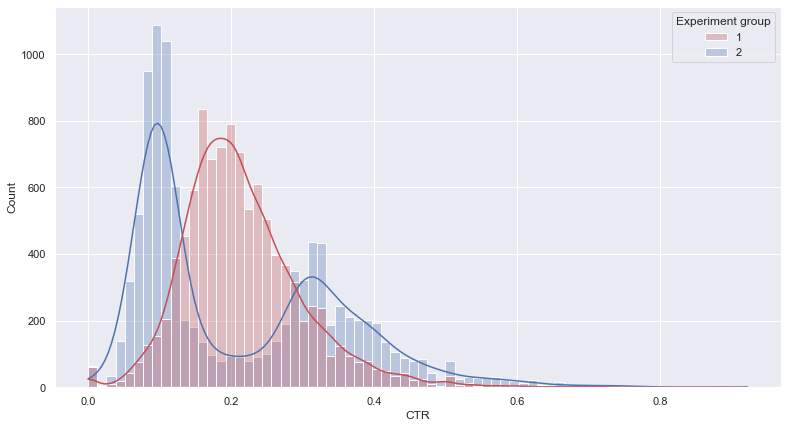

In [66]:
# plot raw ctr
sns.set(rc={'figure.figsize':(13, 7)}) 
df = df.rename(columns=({'exp_group': 'Experiment group'}))
groups = sns.histplot(data = df, 
              x='CTR', 
              hue='Experiment group', 
              palette = ['r', 'b'],
              alpha=0.3,
              kde=True)

Groups really look different. We get it from all the tests, except t-test on raw CTR (not normal distribution). It seems that our new recommendation algo amplified trends. Active people now are more active, passive are more passive. There is no real improving of CTR in average. Maybe the new recommendation algo is worth to use only for active users, not for all of them, that's what we see in bucket test. <br>
So why could happen something like this? <br>
Group 2 get recommendations for posts similar to liked before.<br>
Maybe the algo worked badly for users with low CTR because lack of data for those users and so they get an unappropriate recommendations. Less likes from users - less data. We have more data for active users wand that's why new algo was usefull for them.<br>
We can also suppose that not only activity of user is the factor here, also total lifitime in the application could influence too. New users just don't have enough data for algo input. It's possible to explore deeper by checking correlation between user lifetime in application and changing of CTR in group 2.

***

## 2.6 Linearized metric - addition<a class="anchor" id="linear"></a>

Recall that:<br>
   * group 0 - control
   * group 1 - control
   * group 2 - Recommending posts similar to liked by user before
   * group 3 - Recommending posts liked by other similar users
<br>
<br>
AB test started at '2022-04-04', finished after '2022-04-10'

### Get likes, views, CTR for two groups <a class="anchor" id="lin_data"></a>

In [67]:
# from clickhouse
q = """
SELECT exp_group AS "Experiment group", 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as CTR
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (0, 1, 2 ,3)
GROUP BY "Experiment group", user_id
"""
df = Getch(q).df
# df.groupby('Experiment group').count()

In [68]:
# get data locally
df = read_local_db(q_local, 'AB', '(0, 1, 2, 3)')
df = df.rename(columns=({'exp_group': 'Experiment group'}))
df.groupby('Experiment group').count()

,user_id,likes,views,CTR
Experiment group,,,,
0,9999,9999,9999,9999
1,10079,10079,10079,10079
2,9952,9952,9952,9952
3,10049,10049,10049,10049


### Check data similarity visually <a class="anchor" id="lin_vis"></a>

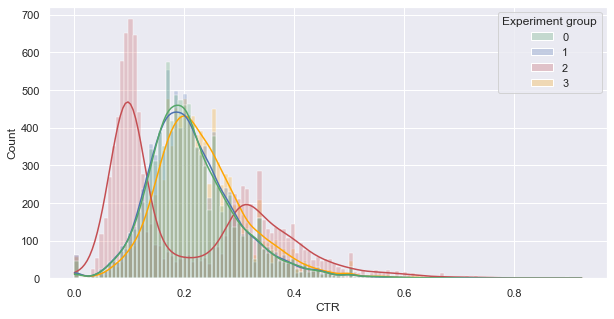

In [69]:
sns.set(rc={'figure.figsize':(10, 5)}) 
groups = sns.histplot(data = df, 
              x='CTR', 
              hue='Experiment group', 
              palette = ['g', 'b', 'r', 'orange'],
              alpha=0.25,
              kde=True)

We will test groups 0 vs 3 and 1 vs 2, let's check it out

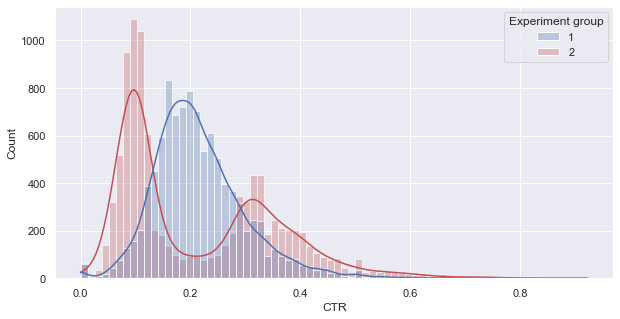

In [70]:
# plot groups 1 and 2
df_1_2 = df[(df['Experiment group'] == 1) | (df['Experiment group'] == 2)] 
groups = sns.histplot(data = df_1_2, 
              x='CTR', 
              hue='Experiment group', 
              palette = ['b', 'r'],
              alpha=0.3,
              kde=True)

Looks much different, will test it anyway to understand the differences better

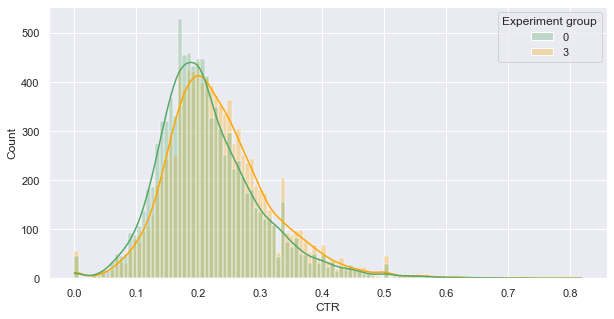

In [71]:
# plot groups 0 and 3
df_0_3 = df[(df['Experiment group'] == 0) | (df['Experiment group'] == 3)] 
groups = sns.histplot(data = df_0_3, 
              x='CTR', 
              hue='Experiment group', 
              palette = ['g', 'orange'],
              alpha=0.3,
              kde=True)

Looks almost the same, group 3 have slightly more higher CTR, but the peak is lower. Will test it statistically further

### Calculating Linearized likes for groups <a class="anchor" id="lin_calc"></a>

In [72]:
# here we implement linearizing of metric CTR, 
# this approach far more robust and guaranteed respectively to smoothed metric
def get_linarized_ctr(df):
    df_result = df.copy()
    ctr_control = df.likes.sum()/df.views.sum()
    df_result['Linearized likes'] = df.likes - df.views*ctr_control
    return df_result

In [73]:
# split to dfs by groups
df_0 = df[df['Experiment group'] == 0]
df_1 = df[df['Experiment group'] == 1]
df_2 = df[df['Experiment group'] == 2]
df_3 = df[df['Experiment group'] == 3]
df_3.head(3)

,Experiment group,user_id,likes,views,CTR
30030,3,200,5.00,16,0.31
30031,3,207,14.00,53,0.26
30032,3,223,12.00,75,0.16


In [74]:
df_0 = get_linarized_ctr(df_0)
df_1 = get_linarized_ctr(df_1)
df_2 = get_linarized_ctr(df_2)
df_3 = get_linarized_ctr(df_3)

In [75]:
df_3.head(3)

,Experiment group,user_id,likes,views,CTR,Linearized likes
30030,3,200,5.00,16,0.31,1.41
30031,3,207,14.00,53,0.26,2.11
30032,3,223,12.00,75,0.16,-4.82


### Plotting new metric - Linearized likes <a class="anchor" id="lin_plot"></a>

In [76]:
df_0_3 = pd.concat([df_0, df_3])
df_1_2 = pd.concat([df_1, df_2])
# df_0_3

In [77]:
# function to plot our metrics
def plot_compare(df, color_list, figsize):
    sns.set(rc={'figure.figsize': figsize}) 
    plt.subplots(1,2)

    plt.subplot(1,2,1)
    plt.title('Original CTR')
    groups = sns.histplot(data = df, 
                  x='CTR', 
                  hue='Experiment group', 
                  palette = color_list,
                  alpha=0.3,
                  kde=True)

    plt.subplot(1,2,2)
    plt.title('Linearized likes')
    groups = sns.histplot(data = df, 
                  x='Linearized likes', 
                  hue='Experiment group', 
                  palette = color_list,
                  alpha=0.3,
                  kde=True)

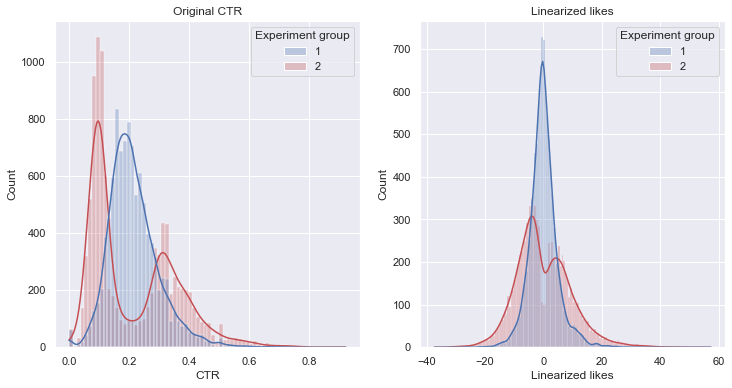

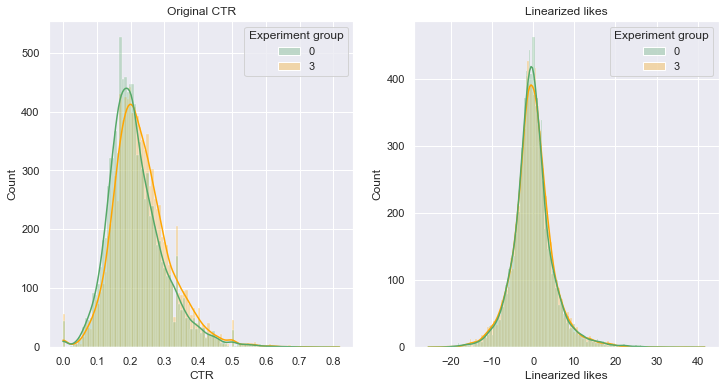

In [78]:
# we will plot updated groups 1 and 2 to compare with original CTR metric
plot_compare(df_1_2, ['b', 'r'], (12, 6))

# we will plot updated groups 0 and 3 to compare with original CTR metric
plot_compare(df_0_3, ['g', 'orange'], (12, 6))

On linearized metric we can see that groups 0 and 3 look much more similar. <br>
Group 1 have __________

### Check the groups by t-test <a class="anchor" id="lin_ttest"></a>

In [79]:
# function to print test result
def print_p_value(p_value, alpha, test_type, metric):     
    print(f'p-value: {p_value}')
    if p_value > alpha:
        print(f'p-value > {alpha}, {metric} of two groups look similar by {test_type}')
    else:
        print(f'p-value <= {alpha}, {metric} of two groups look different by {test_type}')

#### Test groups 1 and 2
Control vs Recommendating posts similar to liked before

In [80]:
statistic, p_value = stats.ttest_ind(df_1['Linearized likes'], df_2['Linearized likes'], equal_var=False)
print_p_value(p_value, .05, 't-test', 'Linearized likes')    
stats.ttest_ind(df_1['Linearized likes'], df_2['Linearized likes'], equal_var=False)

p-value: 0.9999999999999944
p-value > 0.05, Linearized likes of two groups look similar by t-test


Ttest_indResult(statistic=-6.949866187166336e-15, pvalue=0.9999999999999944)

t-test give us p value near 1, looks like groups are almost absolutely similar

**It's hard to believe that it could be a situation, maybe there is something in our data...*

#### Test groups 0 and 3
Control vs Recommendation posts liked by similar users

In [81]:
statistic, p_value = stats.ttest_ind(df_0['Linearized likes'], df_3['Linearized likes'], equal_var=False)
print_p_value(p_value, .05, 't-test', 'Linearized likes')    
stats.ttest_ind(df_0['Linearized likes'], df_3['Linearized likes'], equal_var=False)

p-value: 0.999999999999999
p-value > 0.05, Linearized likes of two groups look similar by t-test


Ttest_indResult(statistic=-1.3032064925201808e-15, pvalue=0.999999999999999)

Wow! p-value is even more close to one! What the mmetric! Or it's just about the t-test

### Check the groups by Mann–Whitney U test <a class="anchor" id="lin_mwh"></a>

#### Test groups 1 and 2
Control vs Recommendating posts similar to liked before

In [82]:
U1, p_value = stats.mannwhitneyu(df_1['Linearized likes'], df_2['Linearized likes'], alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test', 'Linearized likes')    
stats.mannwhitneyu(df_1['Linearized likes'], df_2['Linearized likes'], alternative='two-sided')

p-value: 5.896781159543966e-13
p-value <= 0.05, Linearized likes of two groups look different by Mann–Whitney U test


MannwhitneyuResult(statistic=53100508.0, pvalue=5.896781159543966e-13)

There is no surprise that comparing groups 1 and 2 (which even look so different) we get such low p value

#### Test groups 0 and 3
Control vs Recommendation posts liked by similar users

In [83]:
U1, p_value = stats.mannwhitneyu(df_0['Linearized likes'], df_3['Linearized likes'], alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test', 'Linearized likes')    
stats.mannwhitneyu(df_0['Linearized likes'], df_3['Linearized likes'], alternative='two-sided')

p-value: 0.2566197982423696
p-value > 0.05, Linearized likes of two groups look similar by Mann–Whitney U test


MannwhitneyuResult(statistic=49775173.0, pvalue=0.2566197982423696)

p-value by Mann_Whithney test isn't close one, but anyway larger than our alpha - 0.05

### Additional tests of raw CTR to get complete picture <a class="anchor" id="additional"></a>

#### t-test

Groups 1, 2

In [84]:
statistic, p_value = stats.ttest_ind(df_1.CTR, df_2.CTR, equal_var=False)
print_p_value(p_value, .05, 't-test', 'raw CTR')    
stats.ttest_ind(df_1.CTR, df_2.CTR, equal_var=False)

p-value: 0.4780623130875141
p-value > 0.05, raw CTR of two groups look similar by t-test


Ttest_indResult(statistic=0.7094392041270153, pvalue=0.4780623130875141)

Groups 0, 3

In [85]:
statistic, p_value = stats.ttest_ind(df_0.CTR, df_3.CTR, equal_var=False)
print_p_value(p_value, .05, 't-test', 'raw CTR')    
stats.ttest_ind(df_0.CTR, df_3.CTR, equal_var=False)

p-value: 1.0558494146618204e-43
p-value <= 0.05, raw CTR of two groups look different by t-test


Ttest_indResult(statistic=-13.896870721904117, pvalue=1.0558494146618204e-43)

#### Mann–Whitney U test

Groups 1, 2

In [86]:
U1, p_value = stats.mannwhitneyu(df_1.CTR, df_2.CTR, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test', 'raw CTR')    
stats.mannwhitneyu(df_1.CTR, df_2.CTR, alternative='two-sided')

p-value: 6.0376484617779035e-56
p-value <= 0.05, raw CTR of two groups look different by Mann–Whitney U test


MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Groups 0, 3

In [87]:
U1, p_value = stats.mannwhitneyu(df_0.CTR, df_3.CTR, alternative='two-sided')
print_p_value(p_value, .05, 'Mann–Whitney U test', 'raw CTR')    
stats.mannwhitneyu(df_0.CTR, df_3.CTR, alternative='two-sided')

p-value: 1.1952055473582936e-57
p-value <= 0.05, raw CTR of two groups look different by Mann–Whitney U test


MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

### Construct the table for conclusions <a class="anchor" id="table"></a>

In [92]:
pd.set_option('display.float_format', '{:.2E}'.format)

In [89]:
def color_different(val):
    if val == 'different':
        color = '#993322'
    else:
        color = 'black'
    return 'color: %s' % color

In [93]:
# it's static for now to keep it simple
data = {'Groups': ['1, 2']*4 + ['0, 3']*4, \
        'Algorithm': ['Recommend similar posts']*4 + ['Recommend from similar users']*4, \
        'Test': ['t-test', 'Mann–Whitney']*4, \
        'Metric': (['Linearized likes']*2 + ['CTR']*2)*2, \
        'p-value': [0.999999999999994, 5.89678115954396E-13, 0.478062313087493, 6.0376484617779E-56, 0.999999999999999, 0.256619798242369, 1.05584941466252E-43, 1.19520554735829E-57], \
        'Groups look': (['similar']+['different'])*2 + ['similar']*2 + ['different']*2}

conclusion_table = pd.DataFrame(data)
conclusion_table.style.applymap(color_different)

,Groups,Algorithm,Test,Metric,p-value,Groups look
0,"1, 2",Recommend similar posts,t-test,Linearized likes,1.000000,similar
1,"1, 2",Recommend similar posts,Mann–Whitney,Linearized likes,0.000000,different
2,"1, 2",Recommend similar posts,t-test,CTR,0.478062,similar
3,"1, 2",Recommend similar posts,Mann–Whitney,CTR,0.000000,different
4,"0, 3",Recommend from similar users,t-test,Linearized likes,1.000000,similar
5,"0, 3",Recommend from similar users,Mann–Whitney,Linearized likes,0.256620,similar
6,"0, 3",Recommend from similar users,t-test,CTR,0.000000,different
7,"0, 3",Recommend from similar users,Mann–Whitney,CTR,0.000000,different


### Conclusion about our groups and the Linearized likes metric <a class="anchor" id="lin_conc"></a>

For all groups p-value from `Linearized likes` is higher than p value from raw `CTR`. <br>
This new metric made differences between groups 1 and 2 much clearer, but not changed our conclusion: by Mann–Whitney test groups looks different. (t-test isn't appropriate for this not normal distribution) <br><br>
There is completely another situation for for groups 0 and 3:<br>
We get low p-values from both tests of raw `CTR` (for MW it's of course lower), but from tests of metric `Linearized likes` we get much higher p-values. <br>
So by the the raw `CTR` our groups look different, but by the `Linearized likes` they look similar, like we observe on plots further (same plots as before)

We suppose that metric `Linearized likes` hepls us to get rid from noice, so we accept the following conclusions:<br>
* Groups 1 and 2 have significant differences. <i>Recommendation of posts similar to liked before</i> for sure change the behaviour of users (not like we wanted, as we discussed in previous part)
* Groups 0 and 3 are similar. There is no significant influence by <i>recommendation of posts liked by similar users.</i>

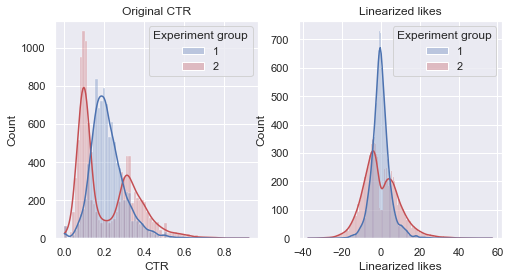

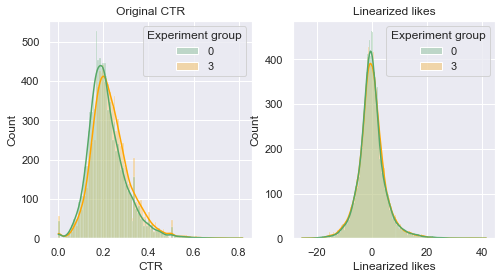

In [91]:
# illustrations for conclusion
figsize = (8, 4)
plot_compare(df_1_2, ['b', 'r'], figsize)
plot_compare(df_0_3, ['g', 'orange'], figsize)

## 2.7 General conclusion <a class="anchor" id="gen_conc"></a>
In this project we used different technicks and approaches to explore our A/B test data and give an answer to the main question: <br><i>"Does the CTR in one group different from the CTR in another group?"</i> <br>Firstly we did the A/A test (chronologically before the A/B test), making sure that we can compare our groups. Then visualized and tested the data from A/B test (raw or transformed).<br>
After all the tests we can declare with confidence that:
* <b>Group 2</b> (<i>Recommendation of posts similar to liked before</i>) <b>is significantly different</b> from control group 1. But this difference isn't positive for our businnes, so we can't recommend deploying this new algorithm on all users. [Details here](#ab_conc)<br>
* <b>Group 3</b> (<i>recommendation of posts liked by similar users.</i>) <b>is similar</b> to control group 0

# 3. Next steps <a class="anchor" id="next"></a>

Next step could be an investigstion about particular users from bucket's quantile visualisation. Are the same users moving left (low CTR) in 20% quantile and the same users are moving right (high CTR) in 80% quantile. <br>
Another thing to do is to repeat the test when our new algo will have more data on users, maybe than the result will be different